<a href="https://colab.research.google.com/github/cSAS3/NIBB-CU-Hackason-2025/blob/main/01_Image%20preprocessing%20/Kingfisher_Auto%E2%80%91Crop_%26_Background_Removal_with_YOLOv8_seine_a_shitani_250722_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[INFO] Loaded crop_512.jpg: 512×512

0: 512x512 1 bird, 250.6ms
Speed: 4.1ms preprocess, 250.6ms inference, 6.3ms postprocess per image at shape (1, 3, 512, 512)
[SAVE] mask_kingfisher.png
[SAVE] kingfisher_no_bg.png

[DISPLAY] Background‑removed Kingfisher


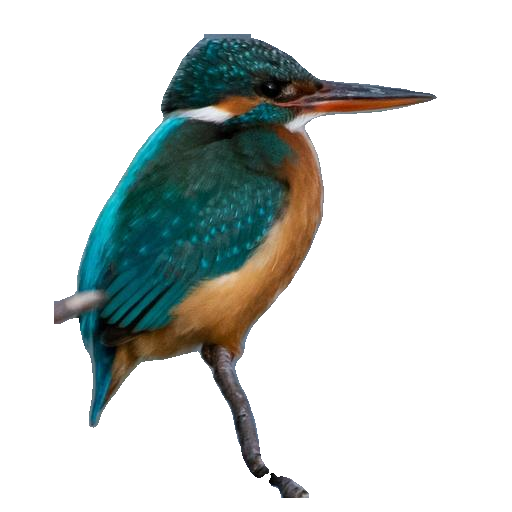

In [3]:
# ============================================================
# Kingfisher Foreground Segmentation & Background Removal  (FIXED)
# ============================================================

!pip -q install ultralytics pillow opencv-python-headless

from ultralytics import YOLO
import cv2, torch, numpy as np
from PIL import Image
from pathlib import Path

# ---------- 1. 設定 ----------------------------------------------------------
INPUT_IMG       = "crop_512.jpg"          # 512×512 のカワセミ画像
MASK_OUT        = "mask_kingfisher.png"   # 0/255 の白黒マスク
TRANSPARENT_OUT = "kingfisher_no_bg.png"  # RGBA 透過 PNG
CONF_THRESH     = 0.25
CLASS_BIRD      = 14                      # COCO = bird

# ---------- 2. 画像読み込み ---------------------------------------------------
img_bgr = cv2.imread(INPUT_IMG)
assert img_bgr is not None, f"{INPUT_IMG} が見つかりません"
h, w = img_bgr.shape[:2]
print(f"[INFO] Loaded {INPUT_IMG}: {w}×{h}")

# ---------- 3. YOLOv8‑seg モデルロード ---------------------------------------
model_seg = YOLO("yolov8n-seg.pt")        # ≒6 MB

# ---------- 4. 推論 (imgsz=画像サイズで統一) ---------------------------------
results = model_seg(img_bgr,
                    imgsz=max(h, w),      # 512 など。ここを合わせると後処理が楽
                    conf=CONF_THRESH,
                    classes=[CLASS_BIRD])

res = results[0]
if res.masks is None or len(res.masks.data) == 0:
    raise RuntimeError("鳥クラスのマスクが検出できませんでした。")

scores   = res.boxes.conf.cpu().numpy()
best_idx = scores.argmax()

mask_prob = res.masks.data[best_idx].cpu().numpy()  # (Hpred, Wpred) = 512×512
mask_bin  = (mask_prob > 0.5).astype(np.uint8)

# ---------- 5. 念のためリサイズで「元画像サイズ」と厳密に合わせる ------------
if mask_bin.shape != (h, w):
    mask_bin = cv2.resize(mask_bin,
                          (w, h),
                          interpolation=cv2.INTER_NEAREST)
    print(f"[INFO] Resized mask to {w}×{h}")

# ---------- 6. マスク画像保存 -------------------------------------------------
mask_img = (mask_bin * 255).astype(np.uint8)
cv2.imwrite(MASK_OUT, mask_img)
print(f"[SAVE] {MASK_OUT}")

# ---------- 7. 透過 PNG 生成 --------------------------------------------------
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
alpha   = mask_img                       # 0‑背景 / 255‑カワセミ
rgba    = np.dstack([img_rgb, alpha])
Image.fromarray(rgba).save(TRANSPARENT_OUT)
print(f"[SAVE] {TRANSPARENT_OUT}")

# ---------- 8. Colab 内プレビュー（任意） ------------------------------------
from IPython.display import display
print("\n[DISPLAY] Background‑removed Kingfisher")
display(Image.open(TRANSPARENT_OUT))
